In [1]:
import numpy as np
import scanpy as sc
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import PROST
PROST.__version__

' 1.1.2 '

In [2]:
#%% init
SEED = 818
PROST.setup_seed(SEED)

# Set directory (If you want to use additional data, please change the file path)
rootdir = 'datasets/osmFISH/'

input_dir = os.path.join(rootdir)
output_dir = os.path.join(rootdir, 'results/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

Trying to set attribute `.obs` of view, copying.
... storing 'ClusterName' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Region' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'Fluorophore' as categorical


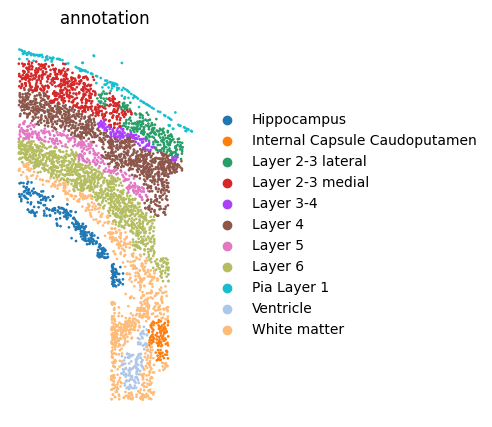

In [3]:
# Read data
adata = sc.read_loom(input_dir+'osmFISH_SScortex_mouse_all_cells.loom')
adata.obsm['spatial'] = adata.obs[['X','Y']].values

# Excluding cells
used_cells = adata.obs.Region!='Excluded'
adata = adata[used_cells,]

# Plot annotation
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="Region",size = 15, show=False, title='annotation')
plt.axis('off')
plt.gca().set_aspect('equal', 'box')
plt.savefig(output_dir+"annotation.png", dpi=600, bbox_inches='tight')

# Save data
adata.write_h5ad(output_dir+"/used_data.h5")

In [4]:
#%% Clustering
# Set the number of clusters
n_clusters = 11     # same as annotation

PROST.setup_seed(SEED)

# Read data
adata = sc.read(output_dir+"/used_data.h5")

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# 3.Run PROST
PROST.run_PNN(adata, 
        platform="osmFISH", 
        min_distance = 800,
        init="mclust",
        n_clusters = n_clusters,  # same as annotation
        tol = 5e-3,
        SEED=SEED,
        lr = 0.1,
        max_epochs = 100)

# 4.Post-process cluster result
adata = PROST.cluster_post_process(adata, 
                                   platform='osmFISH', 
                                   min_distance = 1000, 
                                   key_added = "pp_clustering", 
                                   run_times = 3)

# 5.Calcluate ARI
ARI = metrics.adjusted_rand_score(adata.obs["Region"], adata.obs["pp_clustering"])
print("pp_clustering_ARI =", ARI)


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 102it [02:56,  1.73s/it, loss=0.18372384]                                                                     


Clustering completed !!

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3
pp_clustering_ARI = 0.6766793390568708


In [5]:
#%% Save clustering result
pp_clustering = adata.obs["pp_clustering"] 
embedding = adata.obsm["PROST"]

adata.write_h5ad(output_dir + f"/PNN_result.h5")
pp_clustering.to_csv(output_dir + f"/pp_clusters.csv",header = False)
np.savetxt(output_dir + f"/embedding.txt",embedding)

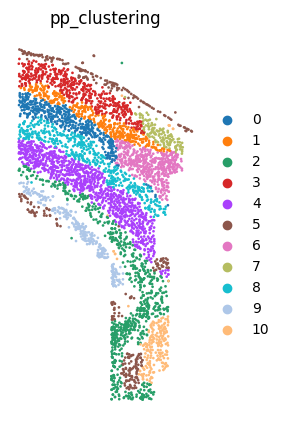

In [6]:
#%% Plot clustering result
adata=sc.read(output_dir + f"/PNN_result.h5")

#
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="pp_clustering", size = 15, show=False, title='pp_clustering')
plt.axis('off')
plt.gca().set_aspect('equal', 'box')
plt.savefig(output_dir + f"/pp_clustering.png", dpi=600, bbox_inches='tight')


In [7]:
#%% Dropout simulation
# Set the number of clusters
n_clusters = 11     # same as annotation

dropout = 0.05 # drop out rate=0.05
adata = PROST.simulateH5Data(adata, rr = dropout)
adata.write_h5ad(output_dir + f"/used_data_drop={dropout}.h5")


dropout rate = 0.05
Done! Remain 105115/110647


In [8]:
#%% Clustering dropout data
adata = sc.read(output_dir + f"/used_data_drop={dropout}.h5")
PROST.setup_seed(SEED)

# 1.Expression data preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# 3.Run PROST
PROST.run_PNN(adata, 
            platform="osmFISH", 
            min_distance = 700,
            init="mclust",
            n_clusters = n_clusters,
            tol = 5e-3,
            SEED=SEED,
            lr = 0.1,
            max_epochs = 100)

# 4.Post-process cluster result
adata = PROST.cluster_post_process(adata, 
                                   platform = 'osmFISH', 
                                   min_distance = 1000, 
                                   key_added = "pp_clustering", 
                                   run_times = 3) 

# 5.Calcluate ARI
ARI = metrics.adjusted_rand_score(adata.obs["Region"], adata.obs["pp_clustering"])
print("pp_clustering_ARI =", ARI)


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 102it [02:54,  1.71s/it, loss=0.19401526]                                                                     


Clustering completed !!

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3
pp_clustering_ARI = 0.6799485227477202


In [9]:
# Save result
pp_clustering = adata.obs["pp_clustering"] 
embedding = adata.obsm["PROST"]

if not os.path.isdir(output_dir + f"/dropout={dropout}/"):
    os.makedirs(output_dir + f"/dropout={dropout}/")
    
pp_clustering.to_csv(output_dir + f"/dropout={dropout}/pp_clusters.csv",header = False)
adata.write_h5ad(output_dir + f"/dropout={dropout}/PNN_result.h5")
np.savetxt(output_dir + f"/dropout={dropout}/embedding.txt",embedding)

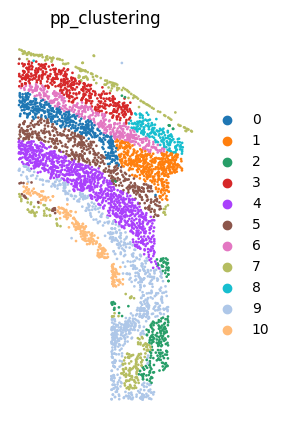

In [10]:
# Plot cluster result
adata=sc.read(output_dir + f"/dropout={dropout}/PNN_result.h5")
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="pp_clustering", size = 15, show=False, title='pp_clustering')
plt.axis('off')
plt.gca().set_aspect('equal', 'box')
plt.savefig(output_dir+f"/dropout={dropout}/pp_clustering.png", dpi=600, bbox_inches='tight')